In [2]:
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import sys, os
sys.path.insert(0, '/'.join(os.path.abspath(os.getcwd()).split('/')[:-1]))
from utils.imports import *
%matplotlib inline

batch_size = 64
learning_rate = 0.01
momentum = 0.5

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed);

In [3]:
test_loader = get_test_loader()
train_loader = get_train_loader(60000)

for (X_train_original, y_train_original) in train_loader:
    pass
for (X_test_original, y_test_original) in test_loader:
    pass

train_loader = get_train_loader(batch_size)
target_label = int(y_test_original[idx_xt])

# Create the torch model and optimizer
model = Net2()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
# torch.save(model.state_dict(), '../models/initial_model.pth')
# torch.save(optimizer.state_dict(), '../models/initial_optimizer.pth')


100%|██████████| 9912422/9912422 [00:00<00:00, 27837696.61it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26495121.13it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 10196579.75it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1578729.49it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [4]:
model

Net2(
  (fc1): Linear(in_features=784, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=10, bias=True)
)

In [ ]:
start = time.time()
mc_output0 = []

for _ in range(400):
    num_epochs = 10
    train_losses, train_counter, test_losses, test_counter = [], [], [], []

    # Load initialized parameters 
    torch.manual_seed(random_seed);
    model.load_state_dict(torch.load('../models/initial_model.pth'))
    optimizer.load_state_dict(torch.load('../models/initial_optimizer.pth'))

    for epoch in range(num_epochs):
        s0 = time.time()
        train(model, optimizer, train_loader, train_losses, train_counter, test_loader, 
              test_losses, test_counter, batch_size, epoch)
        acc = test(model, test_loader, test_losses, test_counter, epoch+1)
        print(f'     Test_Accuracy={acc:.2f}    {print_runtime(s0, False)}')
    acc = test(model, test_loader, test_losses, test_counter, epoch+1)
    save_output0(model, idx_xt, X_test_original)
    output0 = load_output0(idx_xt)
    print(f'output0 (at target_label={target_label}) = {output0[target_label]}     Test_Accuracy={acc:.2f}')
    mc_output0.append(output0)
    print_runtime(start)

epoch: 0   Train_Loss: 0.360331

/Users/ozkansafak/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


     Test_Accuracy=89.76     (...Runtime: 0 min  4 sec)
epoch: 1   Train_Loss: 0.300612     Test_Accuracy=90.25     (...Runtime: 0 min  5 sec)
epoch: 2   Train_Loss: 0.289442     Test_Accuracy=90.48     (...Runtime: 0 min  5 sec)
epoch: 3   Train_Loss: 0.282891     Test_Accuracy=90.71     (...Runtime: 0 min  5 sec)
epoch: 4   Train_Loss: 0.278367     Test_Accuracy=90.83     (...Runtime: 0 min  5 sec)
epoch: 5   Train_Loss: 0.274978     Test_Accuracy=90.93     (...Runtime: 0 min  5 sec)
epoch: 6   Train_Loss: 0.272307     Test_Accuracy=90.97     (...Runtime: 0 min  5 sec)
epoch: 7   Train_Loss: 0.270122     Test_Accuracy=91.01     (...Runtime: 0 min  5 sec)
epoch: 8   Train_Loss: 0.268288     Test_Accuracy=91.05     (...Runtime: 0 min  5 sec)
epoch: 9   Train_Loss: 0.266715     Test_Accuracy=91.11     (...Runtime: 0 min  5 sec)
idx_xt:4966
output0 (at target_label=7) = 0.0024437042884528637     Test_Accuracy=91.11
Runtime: 0 min 56 sec
epoch: 0   Train_Loss: 0.360331     Test_Accuracy=8

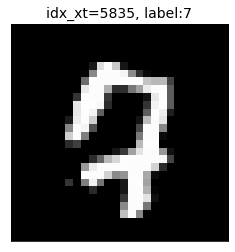

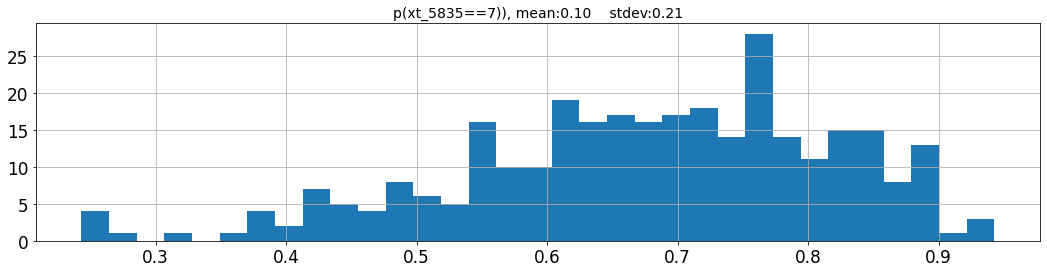

In [48]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(X_test_original[idx_xt][0], cmap='gray', interpolation='none')
plt.title(f'idx_xt={idx_xt}, label:{target_label}', fontsize=14)
plt.xticks([])
plt.yticks([])

fig = plt.figure(figsize=(18,4                                  ))
plt.hist([item[target_label] for item in mc_output0], bins=33);
plt.title(f'p(xt_{idx_xt}=={target_label})), mean:{np.mean(mc_output0):.2f}    stdev:{np.std(mc_output0):.2f}');

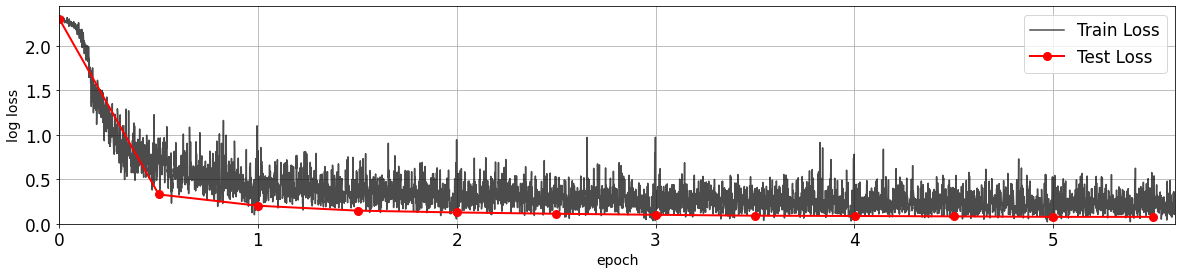

In [41]:
fig = plt.figure(figsize=(20, 4))
plt.plot(train_counter, train_losses, 'k-', alpha=.7)
plt.plot(test_counter, test_losses, 'r.-', linewidth=2, markersize=16)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('epoch', fontsize=14); plt.ylabel('log loss', fontsize=14); plt.xlim(0, train_counter[-1]); plt.ylim(0);

---
## Numerical Gradient Calculation

In [71]:
""" Numerical Gradient Calculation

        Remove each train samples with label target_label one at a time, 
        then train the pytorch model on remaining 59,999 train samples.
"""

start = time.time()
num_epochs = 8
idx_remove = np.argwhere(y_train_original == target_label)[0]

# Initialize dictionary 'grad'
grad = initialize_grad_dict()    
output0 = load_output0(idx_xt)

for q, ir in enumerate(idx_remove):
    if q < len(grad):
        print(f'skipping q:{q}', end='   ')
        continue
    mask = np.ones(len(X_train_original), dtype=bool)
    mask[ir] = False
    X_train = X_train_original[mask]
    y_train = y_train_original[mask]
    train_losses, train_counter, test_losses, test_counter = [], [], [], []

    random_seed = 42
    torch.backends.cudnn.enabled = False
    torch.manual_seed(random_seed);
    model.load_state_dict(torch.load('../models/initial_model.pth'))
    optimizer.load_state_dict(torch.load('../models/initial_optimizer.pth'))

    for epoch in range(num_epochs):
        train_with_torch_tensors(model, optimizer, train_losses, train_counter, test_loader, test_losses, test_counter,
                                 X_train, y_train, batch_size, epoch)
        
    print(f"\n{q}/{len(idx_remove)-1} finished {print_runtime(start, False)}\n")
    
    model.eval()
    output = np.exp(model(X_test_original[idx_xt:idx_xt+1]).detach().numpy())[0]
    grad[ir.detach().tolist()] = output0 - output
    print(f'grad (at target_label={target_label}) = {grad[ir.detach().tolist()][target_label]}')
    
    if (q+1) % 25 == 0:
        with open('../models/grad_dict.pkl', 'wb') as f:
            pickle.dump(grad, f)


initialized empty dictionary: grad = dict()
output0 = [1.0408091e-02 7.6891665e-05 1.8909460e-01 5.3252596e-03 2.8859792e-02
 4.8975304e-05 7.2395410e-06 4.5442128e-01 2.3666047e-02 2.8809178e-01]
softmax prob = [0.01  0.    0.189 0.005 0.029 0.    0.    0.454 0.024 0.288]

------------------------------------------------------------
epoch: 0   Train_Loss: 0.940199   Test_Loss: 0.196387   Test_Accuracy: 94.05%
epoch: 1   Train_Loss: 0.384402   Test_Loss: 0.129749   Test_Accuracy: 96.17%
epoch: 2   Train_Loss: 0.303265   Test_Loss: 0.103060   Test_Accuracy: 96.84%
epoch: 3   Train_Loss: 0.261440   Test_Loss: 0.089767   Test_Accuracy: 97.25%
epoch: 4   Train_Loss: 0.243121   Test_Loss: 0.081411   Test_Accuracy: 97.53%
epoch: 5   Train_Loss: 0.220124   Test_Loss: 0.075747   Test_Accuracy: 97.64%
epoch: 6   Train_Loss: 0.214626   Test_Loss: 0.067093   Test_Accuracy: 97.85%
epoch: 7   Train_Loss: 0.203827   Test_Loss: 0.063184   Test_Accuracy: 98.01%

0/6264 finished  (...Runtime: 0 min 47 

KeyboardInterrupt: 

---

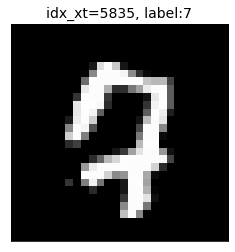

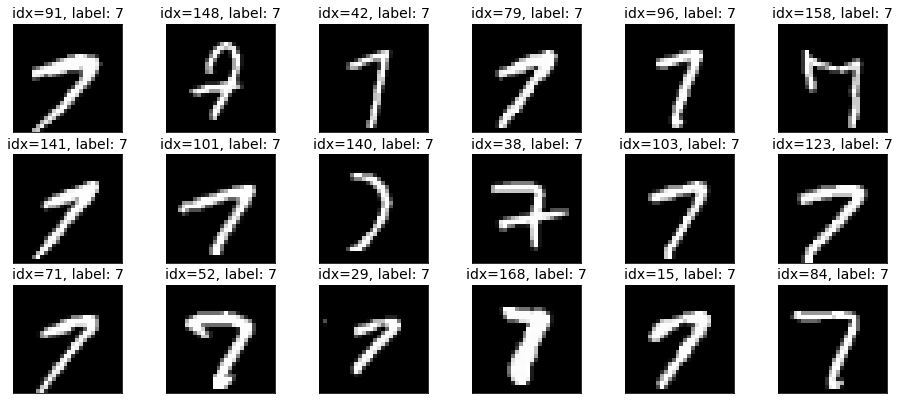

In [31]:
plotter_ranked_sample_importance(X_train_original, X_test_original, target_label, grad)

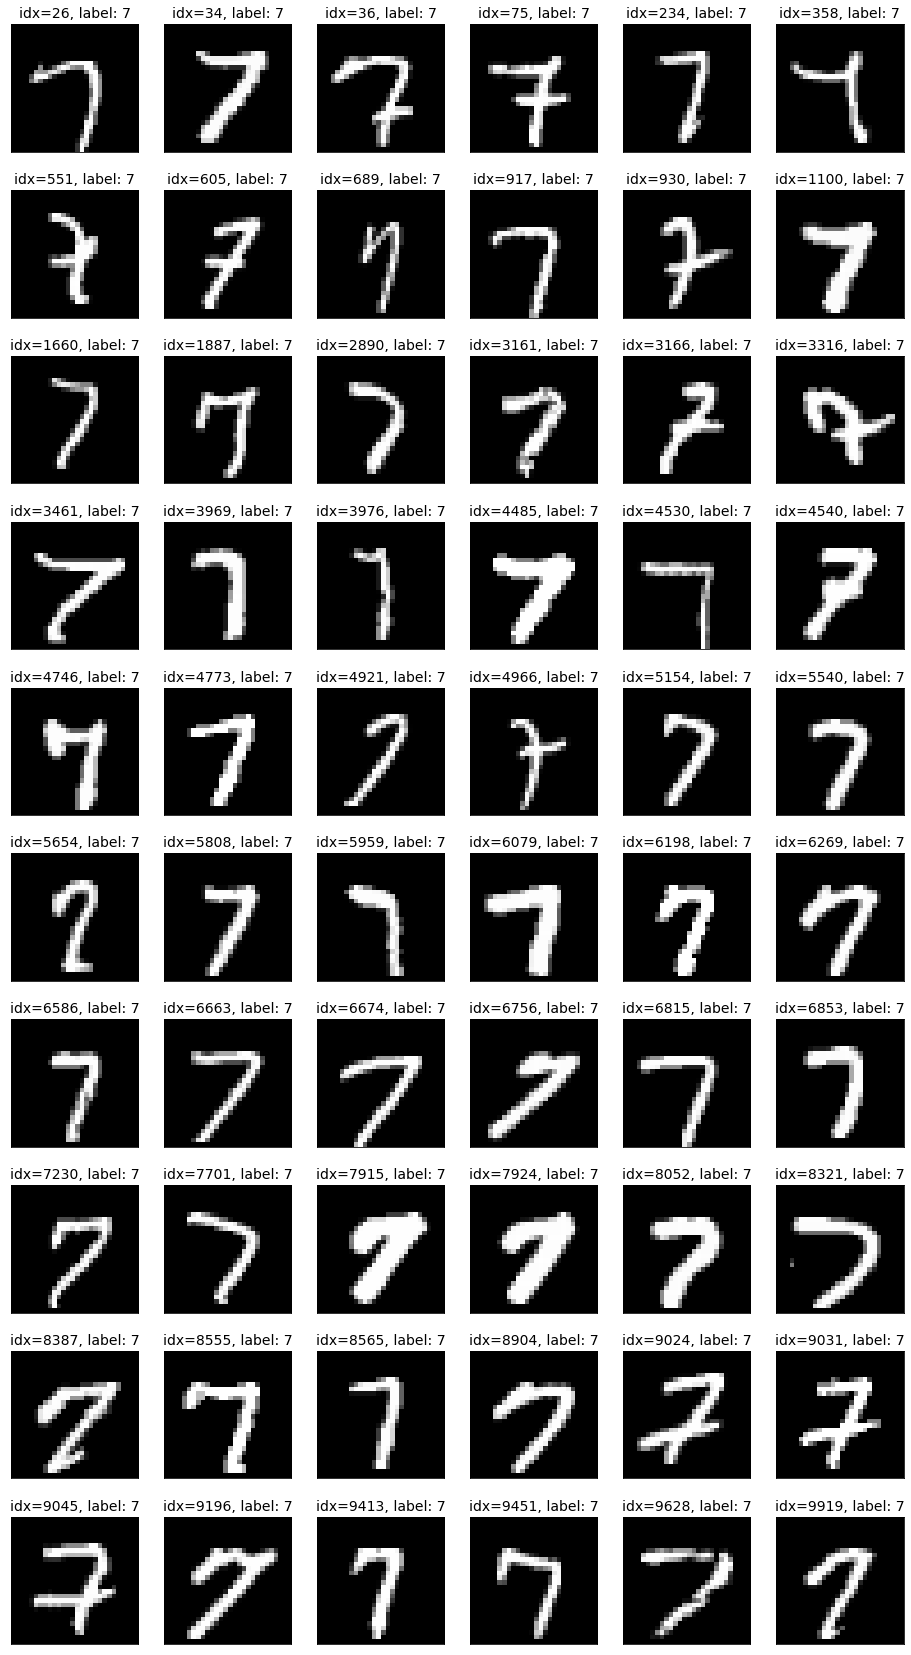

In [6]:
plotter_random_samples(test_loader, num_examples=60, target_label=7)